In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, random, time, copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models, utils

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

from tqdm.auto import tqdm


In [2]:
# ---- User Config ----
DATA_ROOT = "../dataset_4_100img"  # <-- CHANGE THIS
IMG_SIZE   = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
VAL_SIZE   = 0.15   # 15% validation
TEST_SIZE  = 0.15   # 15% test
SEED       = 42
AUGMENT    = True   # toggle augmentations (acts like --augment 1)

LR         = 1e-3
EPOCHS     = 15
PATIENCE   = 25      # Early stopping patience
SAVE_DIR   = "./checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)


In [3]:
# ---- Reproducibility ----
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1) Prepare Dataset (ImageFolder)

In [4]:
# =========================
# 1) LOAD DATASET (ImageFolder)
# =========================
# Basic transform just to read images; augmentation will be applied later only to train subset.
base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=DATA_ROOT, transform=base_transform)
class_names = full_dataset.classes
num_classes = len(class_names)
class_to_idx = full_dataset.class_to_idx

len(full_dataset), class_names, class_to_idx


(467,
 ['Bacterial_Pneu', 'COVID', 'Normal', 'Viral_Pneu'],
 {'Bacterial_Pneu': 0, 'COVID': 1, 'Normal': 2, 'Viral_Pneu': 3})

### 2) Show Dataset Distribution (Before Split)

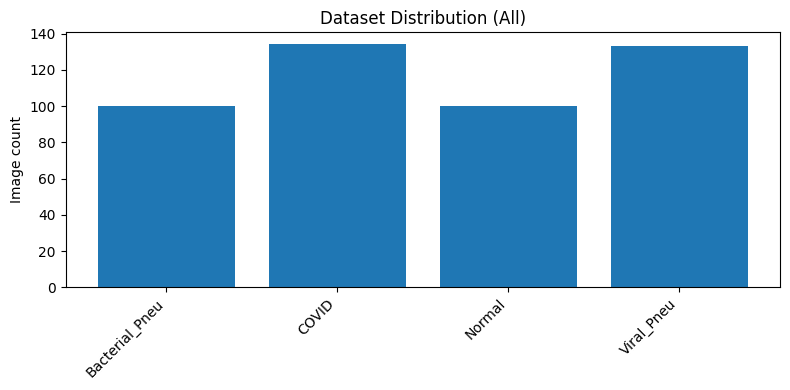

{'Bacterial_Pneu': 100, 'COVID': 134, 'Normal': 100, 'Viral_Pneu': 133}


In [5]:
# =========================
# 2) DATASET DISTRIBUTION (BEFORE SPLIT)
# =========================
# Count targets
targets = np.array([t for _, t in full_dataset.samples])
counts = np.bincount(targets, minlength=num_classes)

plt.figure(figsize=(8,4))
plt.bar(range(num_classes), counts)
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.ylabel("Image count")
plt.title("Dataset Distribution (All)")
plt.tight_layout()
plt.show()

print({cls: int(counts[idx]) for cls, idx in class_to_idx.items()})


### 3) Stratified Split: Train / Val / Test + Distribution Plots

In [6]:
# =========================
# 3) STRATIFIED TRAIN/VAL/TEST SPLIT
# =========================
indices = np.arange(len(full_dataset))
y = targets.copy()

# First split train vs (val+test)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(VAL_SIZE + TEST_SIZE), random_state=SEED)
train_idx, temp_idx = next(sss1.split(indices, y))

# Now split temp into val and test with preserved proportions
temp_y = y[temp_idx]
val_fraction_of_temp = VAL_SIZE / (VAL_SIZE + TEST_SIZE)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=(1 - val_fraction_of_temp), random_state=SEED)
val_idx_rel, test_idx_rel = next(sss2.split(np.arange(len(temp_idx)), temp_y))

val_idx  = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

len(train_idx), len(val_idx), len(test_idx), len(full_dataset)


(326, 70, 71, 467)

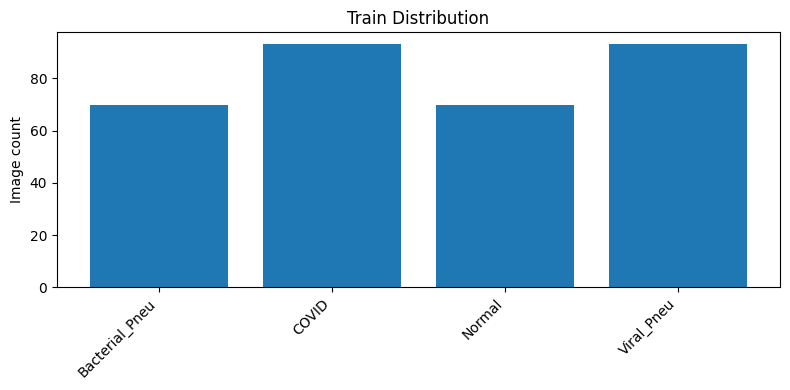

Train Distribution {'Bacterial_Pneu': 70, 'COVID': 93, 'Normal': 70, 'Viral_Pneu': 93}


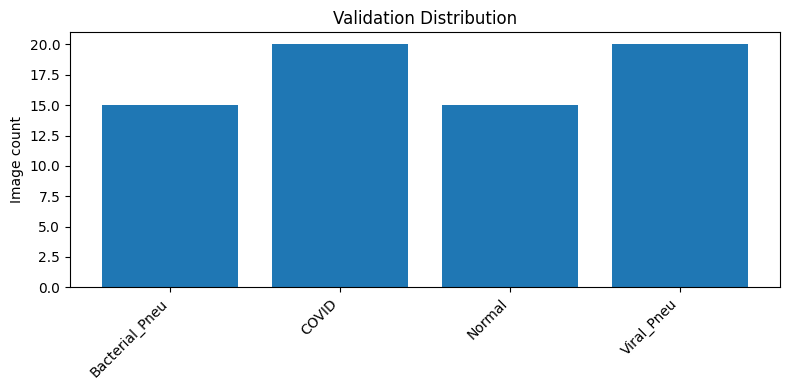

Validation Distribution {'Bacterial_Pneu': 15, 'COVID': 20, 'Normal': 15, 'Viral_Pneu': 20}


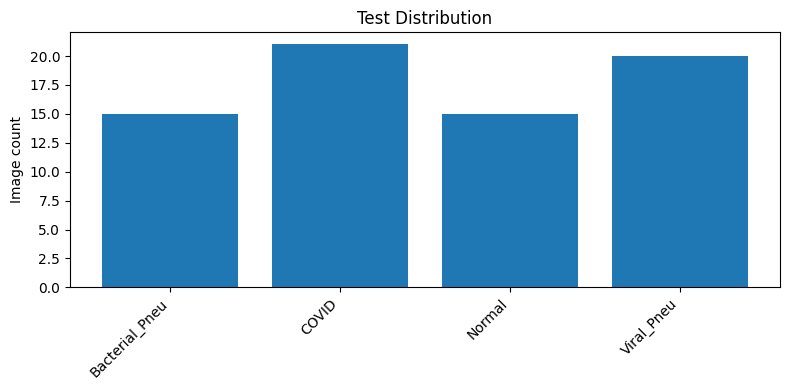

Test Distribution {'Bacterial_Pneu': 15, 'COVID': 21, 'Normal': 15, 'Viral_Pneu': 20}


In [7]:
# ---- Distribution after split ----
def plot_split_distribution(split_indices, title):
    split_targets = y[split_indices]
    counts = np.bincount(split_targets, minlength=num_classes)
    plt.figure(figsize=(8,4))
    plt.bar(range(num_classes), counts)
    plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
    plt.ylabel("Image count")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    print(title, {class_names[i]: int(c) for i, c in enumerate(counts)})

plot_split_distribution(train_idx, "Train Distribution")
plot_split_distribution(val_idx,   "Validation Distribution")
plot_split_distribution(test_idx,  "Test Distribution")


### 4) Augmentations (Train only) + Preview

In [8]:
# =========================
# 4) DATA AUGMENTATIONS
# =========================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5) if AUGMENT else transforms.Lambda(lambda x: x),
    transforms.RandomRotation(degrees=15)   if AUGMENT else transforms.Lambda(lambda x: x),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2) if AUGMENT else transforms.Lambda(lambda x: x),
    transforms.ToTensor(),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Create split datasets with respective transforms
# We wrap Subset to apply different transforms by overriding dataset.transform dynamically.
class TransformingSubset(Subset):
    def __init__(self, dataset, indices, transform):
        super().__init__(dataset, indices)
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        # dataset already applied base_transform; we re-load original path to apply fresh transforms
        path, target = self.dataset.samples[self.indices[idx]]
        img = self.dataset.loader(path)
        if self.transform:
            img = self.transform(img)
        return img, target

train_ds = TransformingSubset(full_dataset, train_idx, train_transform)
val_ds   = TransformingSubset(full_dataset, val_idx,   eval_transform)
test_ds  = TransformingSubset(full_dataset, test_idx,  eval_transform)

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(326, 70, 71)

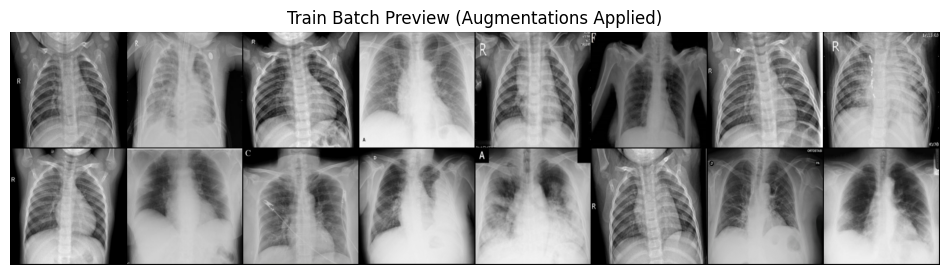

In [9]:
# ---- Augmentation preview ----
def show_batch(loader, title="Batch Preview", max_images=16):
    batch = next(iter(loader))
    imgs, labels = batch
    grid = utils.make_grid(imgs[:max_images], nrow=8, padding=2)
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title(title)
    plt.show()

show_batch(train_loader, "Train Batch Preview (Augmentations Applied)" if AUGMENT else "Train Batch Preview (No Augment)")


### 5) Build Model (ResNet18) + Loss/Optimizer/Scheduler

In [10]:
# =========================
# 5) MODEL
# =========================
# Use a torchvision model (ResNet18). Fine-tune the final layer.
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)


### 6) Callbacks: EarlyStopping + ModelCheckpoint

In [11]:
# =========================
# 6) CALLBACKS (EarlyStopping, Checkpoint)
# =========================
class EarlyStopping:
    def __init__(self, patience=PATIENCE, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = np.inf
        self.counter = 0
        self.should_stop = False

    def step(self, val_loss):
        if val_loss < (self.best - self.min_delta):
            self.best = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

best_ckpt_path = os.path.join(SAVE_DIR, "best_model.pt")


### 7) Train Loop (with validation, early stop, checkpoint)

In [12]:
# =========================
# 7) TRAINING
# =========================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(loader, leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
early = EarlyStopping(patience=PATIENCE)
best_val = np.inf

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss);   history["val_acc"].append(val_acc)

    # Save best
    if val_loss < best_val:
        best_val = val_loss
        torch.save({"model_state": model.state_dict(),
                    "class_names": class_names}, best_ckpt_path)

    # Early Stop
    early.step(val_loss)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | "
          f"time={(time.time()-t0):.1f}s")

    if early.should_stop:
        print("Early stopping triggered.")
        break

# Load best checkpoint
ckpt = torch.load(best_ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 01/15 | train_loss=0.6513 acc=0.7147 | val_loss=2.9924 acc=0.3857 | time=1.8s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 02/15 | train_loss=0.5250 acc=0.7454 | val_loss=1.1803 acc=0.6714 | time=21.3s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 03/15 | train_loss=0.3795 acc=0.8405 | val_loss=34.5586 acc=0.3143 | time=1.3s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 04/15 | train_loss=0.3290 acc=0.8497 | val_loss=0.6507 acc=0.8143 | time=1.1s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 05/15 | train_loss=0.2125 acc=0.9110 | val_loss=0.8962 acc=0.7714 | time=1.1s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 06/15 | train_loss=0.1741 acc=0.9325 | val_loss=1.8408 acc=0.6000 | time=1.1s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 07/15 | train_loss=0.2520 acc=0.9233 | val_loss=1.4088 acc=0.5429 | time=1.1s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 08/15 | train_loss=0.1461 acc=0.9479 | val_loss=0.8128 acc=0.7714 | time=1.2s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 09/15 | train_loss=0.1332 acc=0.9479 | val_loss=2.0368 acc=0.6000 | time=1.2s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10/15 | train_loss=0.1270 acc=0.9448 | val_loss=0.8523 acc=0.7143 | time=1.3s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11/15 | train_loss=0.1031 acc=0.9663 | val_loss=0.6798 acc=0.8143 | time=1.2s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12/15 | train_loss=0.0718 acc=0.9663 | val_loss=0.5805 acc=0.8429 | time=101.3s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13/15 | train_loss=0.0332 acc=0.9908 | val_loss=0.6033 acc=0.8429 | time=1.4s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14/15 | train_loss=0.0169 acc=1.0000 | val_loss=0.6607 acc=0.8571 | time=1.1s


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15/15 | train_loss=0.0268 acc=0.9908 | val_loss=0.6732 acc=0.8571 | time=1.1s


<All keys matched successfully>

### 8) Training & Validation Curves (side-by-side)

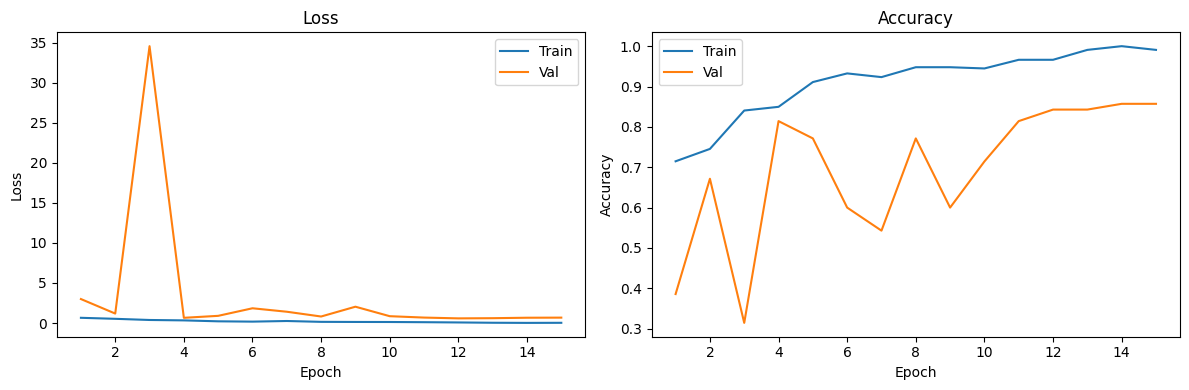

In [13]:
# =========================
# 8) TRAIN/VAL CURVES
# =========================
epochs_ran = range(1, len(history["train_loss"])+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_ran, history["train_loss"], label="Train")
plt.plot(epochs_ran, history["val_loss"],   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_ran, history["train_acc"], label="Train")
plt.plot(epochs_ran, history["val_acc"],   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()


### 9) Evaluation on Test Set

In [14]:
# =========================
# 9) EVALUATION
# =========================
@torch.no_grad()
def predict_all(model, loader, device):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())
    return np.concatenate(all_probs), np.concatenate(all_preds), np.concatenate(all_labels)

probs_test, preds_test, labels_test = predict_all(model, test_loader, device)
test_acc = (preds_test == labels_test).mean()
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7887


### 10) Confusion Matrix (counts + normalized)

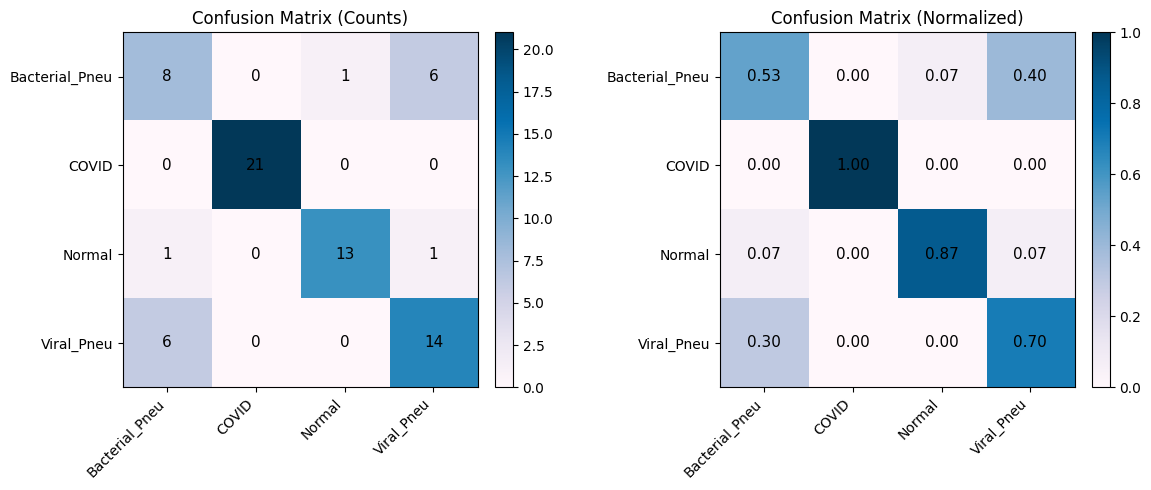

In [15]:
# =========================
# 10) CONFUSION MATRIX (Blush Theme)
# =========================
cm = confusion_matrix(labels_test, preds_test, labels=range(num_classes))
cm_norm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Confusion Matrix (Counts) ---
im0 = ax[0].imshow(cm, interpolation='nearest', cmap='PuBu')
ax[0].set_title("Confusion Matrix (Counts)", fontsize=12)
ax[0].set_xticks(range(num_classes))
ax[0].set_xticklabels(class_names, rotation=45, ha="right")
ax[0].set_yticks(range(num_classes))
ax[0].set_yticklabels(class_names)
for i in range(num_classes):
    for j in range(num_classes):
        ax[0].text(j, i, cm[i, j], ha="center", va="center", fontsize=11, color="black")
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# --- Confusion Matrix (Normalized) ---
im1 = ax[1].imshow(cm_norm, interpolation='nearest', cmap='PuBu')
ax[1].set_title("Confusion Matrix (Normalized)", fontsize=12)
ax[1].set_xticks(range(num_classes))
ax[1].set_xticklabels(class_names, rotation=45, ha="right")
ax[1].set_yticks(range(num_classes))
ax[1].set_yticklabels(class_names)
for i in range(num_classes):
    for j in range(num_classes):
        ax[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", fontsize=11, color="black")
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


### 11) Classification Report

In [16]:
# =========================
# 11) CLASSIFICATION REPORT
# =========================
report = classification_report(labels_test, preds_test, target_names=class_names, digits=4)
print(report)

                precision    recall  f1-score   support

Bacterial_Pneu     0.5333    0.5333    0.5333        15
         COVID     1.0000    1.0000    1.0000        21
        Normal     0.9286    0.8667    0.8966        15
    Viral_Pneu     0.6667    0.7000    0.6829        20

      accuracy                         0.7887        71
     macro avg     0.7821    0.7750    0.7782        71
  weighted avg     0.7924    0.7887    0.7902        71



### 12) ROC–AUC (per-class + micro/macro)

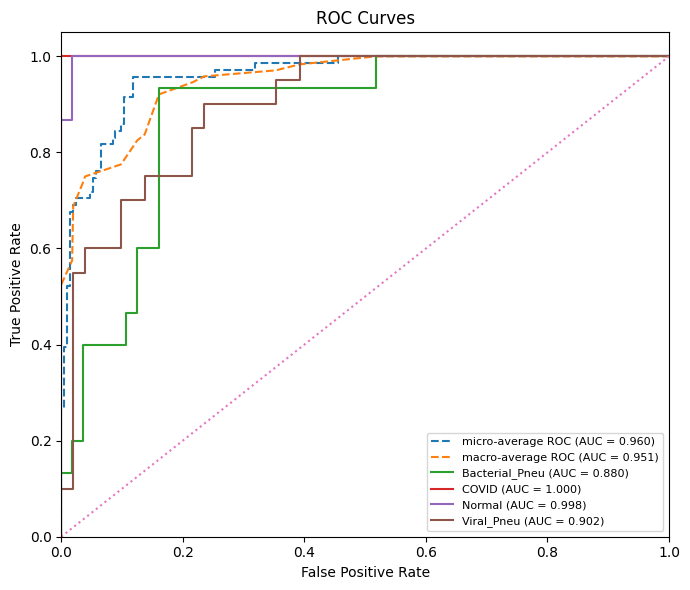

In [17]:
# =========================
# 12) ROC–AUC (per-class + micro/macro)
# =========================
# Binarize labels for multi-class ROC
labels_bin = label_binarize(labels_test, classes=list(range(num_classes)))
# If only 2 classes, label_binarize returns shape (n,1); handle consistently
if labels_bin.shape[1] == 1:
    labels_bin = np.hstack([1 - labels_bin, labels_bin])  # make it 2 columns
    probs_test = np.hstack([1 - probs_test, probs_test])

# Per-class ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
# Aggregate all FPRs
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure(figsize=(7,6))
plt.plot(fpr["micro"], tpr["micro"], linestyle='--', label=f"micro-average ROC (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label=f"macro-average ROC (AUC = {roc_auc['macro']:.3f})")
for i, cls in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.3f})")
plt.plot([0,1], [0,1], linestyle=':')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()


### 13) Prediction Gallery (green = correct, red = wrong)

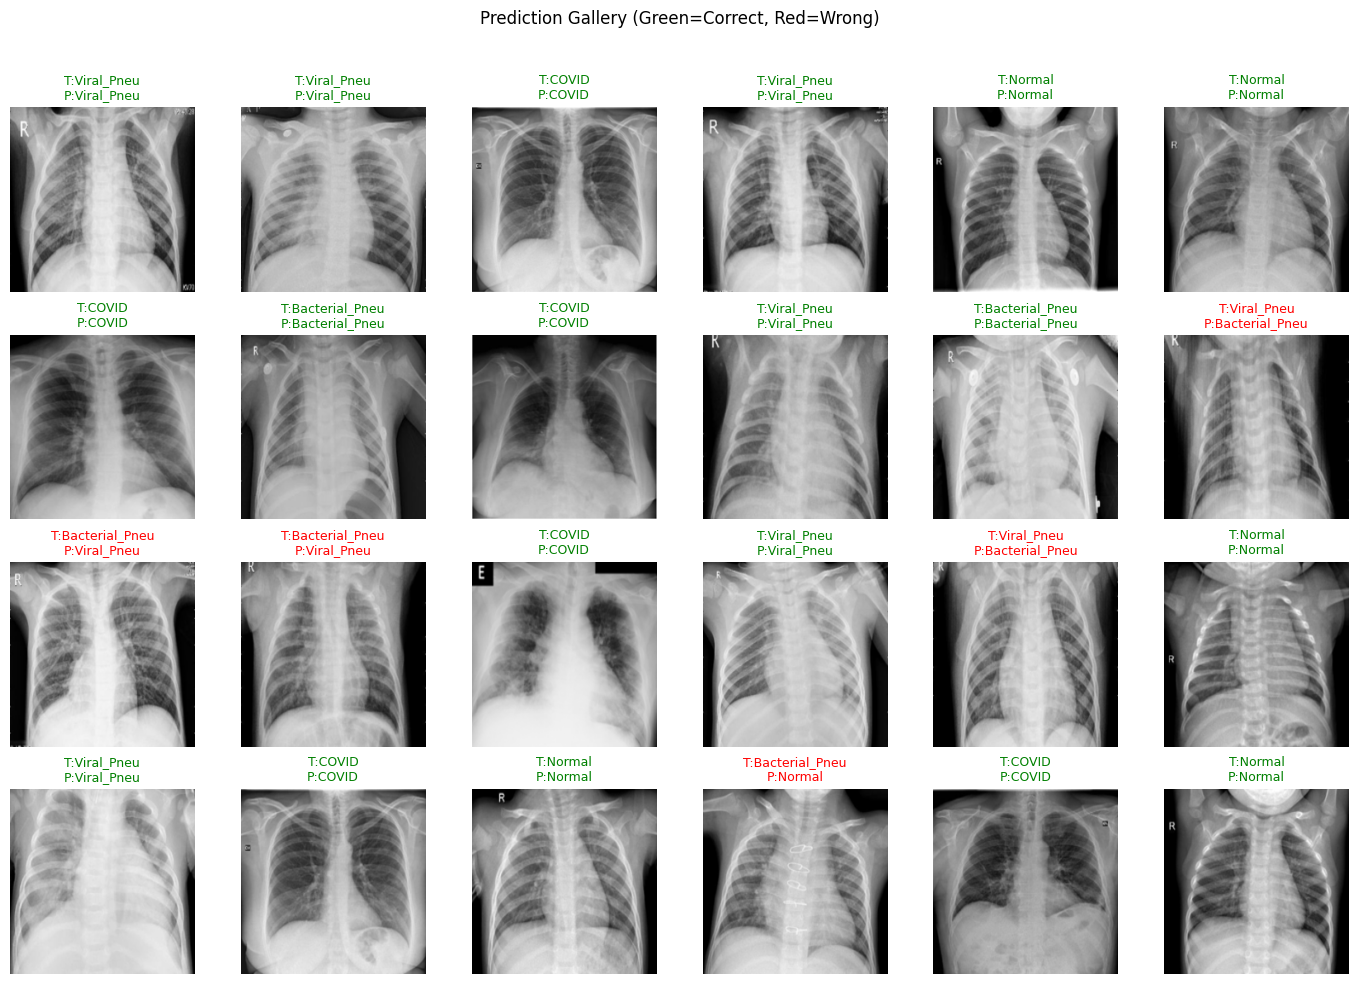

In [18]:
# =========================
# 13) PREDICTION GALLERY
# =========================
# We'll take a batch from the test loader and visualize.
def prediction_gallery(model, loader, class_names, max_images=24):
    model.eval()
    imgs_list, y_true_list, y_pred_list = [], [], []

    with torch.no_grad():
        for imgs, labels in loader:
            logits = model(imgs.to(device))
            preds = logits.argmax(1).cpu()
            imgs_list.append(imgs)
            y_true_list.append(labels)
            y_pred_list.append(preds)
            if sum(x.size(0) for x in imgs_list) >= max_images:
                break

    imgs = torch.cat(imgs_list, dim=0)[:max_images]
    y_true = torch.cat(y_true_list, dim=0)[:max_images]
    y_pred = torch.cat(y_pred_list, dim=0)[:max_images]

    n = imgs.size(0)
    ncols = 6
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(14, 2.4*nrows))
    for i in range(n):
        ax = plt.subplot(nrows, ncols, i+1)
        img = np.transpose(imgs[i].numpy(), (1,2,0))
        ax.imshow(img)
        ax.axis('off')
        correct = (y_true[i].item() == y_pred[i].item())
        color = "green" if correct else "red"
        ax.set_title(f"T:{class_names[y_true[i]]}\nP:{class_names[y_pred[i]]}", color=color, fontsize=9)
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(2.0)
    plt.suptitle("Prediction Gallery (Green=Correct, Red=Wrong)", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

prediction_gallery(model, test_loader, class_names, max_images=24)
